# Private Housing Resale Price Prediction
- This file is dedicated to predicting private housing resale prices.
- Our problem statement involves predicting resale prices of private housing resale prices based on features such as postal district and etc.
- This is a regression problem hence we will use appropriate regression models.

- Done By: Muhammad Hasan Bin Suwandi
- Admin Number: 190246N

## Data Collection
- The following codes below in this section is dedicated to reading and combining csv files into 1 dataframe.
- We also import all necessary modules in this section as well.
- Data is retrieved from Private Residential Property Transactions from https://www.ura.gov.sg/realEstateIIWeb/transaction/search.action .

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import glob
import xgboost as xg
import pickle


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Read csv files for private housing data
privateHouseFile = "../dataset/sale-prediction/private-housing/*.csv"
all_private_sales = glob.glob(privateHouseFile)

listOfPrivate = []
for filename in all_private_sales:
    df = pd.read_csv(filename, skiprows=1)
    listOfPrivate.append(df)

# Merge pandas dataframes in the list
privateDf = pd.concat(listOfPrivate, axis=0)
privateDf.reset_index(drop=True, inplace=True)
privateDf.head()

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,1,ECHELON,ALEXANDRA VIEW,Condominium,03,RCR,99 yrs lease commencing from 2012,Resale,1.0,2000000.0,-,93.0,Strata,41 to 45,21505.0,May-2021
1,2,CARIBBEAN AT KEPPEL BAY,KEPPEL BAY DRIVE,Condominium,04,RCR,99 yrs lease commencing from 1999,Resale,1.0,2300000.0,-,141.0,Strata,01 to 05,16312.0,May-2021
2,3,LUMIERE,MISTRI ROAD,Apartment,02,CCR,99 yrs lease commencing from 2006,Resale,1.0,1251300.0,-,60.0,Strata,36 to 40,20855.0,May-2021
3,4,ASCENTIA SKY,ALEXANDRA VIEW,Condominium,03,RCR,99 yrs lease commencing from 2008,Resale,1.0,2530000.0,-,169.0,Strata,16 to 20,14970.0,May-2021
4,5,HUNDRED TREES,WEST COAST DRIVE,Condominium,05,OCR,956 yrs lease commencing from 1928,Resale,1.0,1150000.0,-,73.0,Strata,01 to 05,15753.0,May-2021


In [3]:
# Checks how many rows/columns are there
# There are 63895 rows and 16 columns
privateDf.shape

(63895, 16)

In [4]:
# Check data types of columns
privateDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63895 entries, 0 to 63894
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   S/N                63748 non-null  object 
 1   Project Name       63853 non-null  object 
 2   Street Name        63619 non-null  object 
 3   Type               63618 non-null  object 
 4   Postal District    63618 non-null  object 
 5   Market Segment     63601 non-null  object 
 6   Tenure             63597 non-null  object 
 7   Type of Sale       63601 non-null  object 
 8   No. of Units       63601 non-null  float64
 9   Price ($)          63601 non-null  float64
 10  Nett Price ($)     63601 non-null  object 
 11  Area (Sqm)         63601 non-null  float64
 12  Type of Area       63601 non-null  object 
 13  Floor Level        63601 non-null  object 
 14  Unit Price ($psm)  63601 non-null  float64
 15  Date of Sale       63601 non-null  object 
dtypes: float64(4), object(

In [5]:
# Find out mean, median, standard deviation, etc
privateDf.describe()

,No. of Units,Price ($),Area (Sqm),Unit Price ($psm)
count,63601.000000,6.360100e+04,63601.000000,63601.000000
mean,1.104951,2.349279e+06,164.658873,13938.754139
std,4.725084,1.242689e+07,747.378357,5505.148333
min,1.000000,4.000000e+04,24.000000,355.000000
25%,1.000000,1.005000e+06,89.000000,10194.000000
50%,1.000000,1.428000e+06,116.000000,12773.000000
75%,1.000000,2.300000e+06,159.000000,16400.000000
max,560.000000,9.800000e+08,87986.000000,64848.000000


## Data Preparation
- In this section, we will check if our data contains null/empty values and fill in empty data with mean values.
- We will also convert column data to correct data types.

In [6]:
# Some fields are empty
# In this case, we check the cause of missing rows
privateDf.isnull().sum()

S/N                  147
Project Name          42
Street Name          276
Type                 277
Postal District      277
Market Segment       294
Tenure               298
Type of Sale         294
No. of Units         294
Price ($)            294
Nett Price ($)       294
Area (Sqm)           294
Type of Area         294
Floor Level          294
Unit Price ($psm)    294
Date of Sale         294
dtype: int64

In [7]:
row_has_NaN = privateDf.isnull().any(axis=1)
rows = privateDf[row_has_NaN]
rows.head()
# rows.info()

# Just by checking null values, we can tell that they are totally not related to our data at all.
# Just descriptions of the data located at the bottom of each csv files.
# Therefore, we just drop these rows.

,S/N,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
6317,6317 record(s) retrieved based on user-specifi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6318,Search By Period (MAY 2016 to MAY 2021) & Prop...,02,03,04,05 & Type of Sale: Resale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6319,Notes:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6320,1,"For conventional landed housing, the area pert...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6321,NaN,For strata sub-divided housing such as apartme...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# We drop empty rows here
privateDf = privateDf.dropna()
privateDf.isnull().sum()

S/N                  0
Project Name         0
Street Name          0
Type                 0
Postal District      0
Market Segment       0
Tenure               0
Type of Sale         0
No. of Units         0
Price ($)            0
Nett Price ($)       0
Area (Sqm)           0
Type of Area         0
Floor Level          0
Unit Price ($psm)    0
Date of Sale         0
dtype: int64

In [9]:
# Drop project name and street name columns as they are irrelevant
# Drop S/N since we already have a index column
# Drop type of sale because we are only dealing with resale only
privateDf = privateDf.drop(['S/N','Project Name','Street Name','Type of Sale'], axis=1)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,Condominium,03,RCR,99 yrs lease commencing from 2012,1.0,2000000.0,-,93.0,Strata,41 to 45,21505.0,May-2021
1,Condominium,04,RCR,99 yrs lease commencing from 1999,1.0,2300000.0,-,141.0,Strata,01 to 05,16312.0,May-2021
2,Apartment,02,CCR,99 yrs lease commencing from 2006,1.0,1251300.0,-,60.0,Strata,36 to 40,20855.0,May-2021
3,Condominium,03,RCR,99 yrs lease commencing from 2008,1.0,2530000.0,-,169.0,Strata,16 to 20,14970.0,May-2021
4,Condominium,05,OCR,956 yrs lease commencing from 1928,1.0,1150000.0,-,73.0,Strata,01 to 05,15753.0,May-2021


In [10]:
# We check if any rows contain any useful value related to Nett Price ($)
# But turns out there is nothing relevant there
# So we drop that column
privateDf[privateDf['Nett Price ($)'] != '-']

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Nett Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale


In [11]:
# Drop Nett Price Columns
privateDf = privateDf.drop(['Nett Price ($)'], axis=1)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,Condominium,03,RCR,99 yrs lease commencing from 2012,1.0,2000000.0,93.0,Strata,41 to 45,21505.0,May-2021
1,Condominium,04,RCR,99 yrs lease commencing from 1999,1.0,2300000.0,141.0,Strata,01 to 05,16312.0,May-2021
2,Apartment,02,CCR,99 yrs lease commencing from 2006,1.0,1251300.0,60.0,Strata,36 to 40,20855.0,May-2021
3,Condominium,03,RCR,99 yrs lease commencing from 2008,1.0,2530000.0,169.0,Strata,16 to 20,14970.0,May-2021
4,Condominium,05,OCR,956 yrs lease commencing from 1928,1.0,1150000.0,73.0,Strata,01 to 05,15753.0,May-2021


In [12]:
# Convert month column to 'month' type
privateDf['Date of Sale'] = pd.to_datetime(privateDf['Date of Sale'],format='%b-%Y')
# Convert month to ordinal type so we can use the data for training our model
privateDf['Date of Sale'] = privateDf['Date of Sale'].map(dt.datetime.toordinal)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm),Date of Sale
0,Condominium,03,RCR,99 yrs lease commencing from 2012,1.0,2000000.0,93.0,Strata,41 to 45,21505.0,737911
1,Condominium,04,RCR,99 yrs lease commencing from 1999,1.0,2300000.0,141.0,Strata,01 to 05,16312.0,737911
2,Apartment,02,CCR,99 yrs lease commencing from 2006,1.0,1251300.0,60.0,Strata,36 to 40,20855.0,737911
3,Condominium,03,RCR,99 yrs lease commencing from 2008,1.0,2530000.0,169.0,Strata,16 to 20,14970.0,737911
4,Condominium,05,OCR,956 yrs lease commencing from 1928,1.0,1150000.0,73.0,Strata,01 to 05,15753.0,737911


In [13]:
# Create new feature called price per unit
privateDf['Price Per Unit ($/unit)'] = privateDf['Price ($)'] / privateDf['No. of Units']

# Create another new feature called unit size
privateDf['Area Per Unit (sqm/unit)'] = privateDf['Area (Sqm)'] / privateDf['No. of Units']

In [14]:
# plt.figure(figsize=[55,55])

# sns.heatmap(privateDf.corr(), vmin=0, vmax=1, annot=True)
# We drop these following columns since our users are only buying one unit of house
# And we exclude Price ($) column since it includes total price of the property which contains multiple units
privateDf = privateDf.drop(['No. of Units','Price ($)','Unit Price ($psm)','Area (Sqm)'], axis=1)
privateDf.head()

,Type,Postal District,Market Segment,Tenure,Type of Area,Floor Level,Date of Sale,Price Per Unit ($/unit),Area Per Unit (sqm/unit)
0,Condominium,03,RCR,99 yrs lease commencing from 2012,Strata,41 to 45,737911,2000000.0,93.0
1,Condominium,04,RCR,99 yrs lease commencing from 1999,Strata,01 to 05,737911,2300000.0,141.0
2,Apartment,02,CCR,99 yrs lease commencing from 2006,Strata,36 to 40,737911,1251300.0,60.0
3,Condominium,03,RCR,99 yrs lease commencing from 2008,Strata,16 to 20,737911,2530000.0,169.0
4,Condominium,05,OCR,956 yrs lease commencing from 1928,Strata,01 to 05,737911,1150000.0,73.0


In [15]:
# Values of postal district is not standardised
privateDf['Postal District'].unique()

array(['03', '04', '02', '05', '01', '14', '12', '15', '13', '11', '19',
       '18', '16', '20', '17', '23', '21', '22', '26', '25', 27.0, 28.0,
       '10', '09', '08', '07', '06', 26.0], dtype=object)

In [16]:
# Standardised Postal District Naming
privateDf['Postal District'] = privateDf['Postal District'].replace({26.0: 26, 27.0: 27, 28.0: 28})
privateDf['Postal District'].unique()

array([ 3,  4,  2,  5,  1, 14, 12, 15, 13, 11, 19, 18, 16, 20, 17, 23, 21,
       22, 26, 25, 27, 28, 10,  9,  8,  7,  6], dtype=int64)

In [17]:
# We see what type of area the house is
privateDf['Type of Area'].unique()

array(['Strata', 'Land'], dtype=object)

In [18]:
# We check what type of private housing is available
# We can merge some values together such as 'Strata Terrace' and 'Terrace' together since both are terrace houses with different of 'type of area' values.
privateDf['Type'].unique()

array(['Condominium', 'Apartment', 'Executive Condominium', 'Terrace',
       'Detached', 'Semi-detached', 'Strata Terrace',
       'Strata Semi-detached', 'Strata Detached'], dtype=object)

In [19]:
# For further understanding, we can see data related to strata terrace should type of area be 'Strata'
privateDf[(privateDf['Type of Area'] == "Strata") & (privateDf['Type'] == 'Strata Terrace')]

,Type,Postal District,Market Segment,Tenure,Type of Area,Floor Level,Date of Sale,Price Per Unit ($/unit),Area Per Unit (sqm/unit)
62635,Strata Terrace,28,OCR,Freehold,Strata,-,737911,2550000.0,318.0
62636,Strata Terrace,28,OCR,Freehold,Strata,-,737911,3100000.0,369.0
62637,Strata Terrace,28,OCR,999 yrs lease commencing from 1879,Strata,-,737911,2370000.0,313.0
62638,Strata Terrace,28,OCR,99 yrs lease commencing from 2013,Strata,-,737911,1750000.0,142.0
62639,Strata Terrace,28,OCR,Freehold,Strata,-,737911,3190000.0,333.0
...,...,...,...,...,...,...,...,...,...
63871,Strata Terrace,10,CCR,Freehold,Strata,-,736389,4000000.0,413.0
63873,Strata Terrace,10,CCR,Freehold,Strata,-,736238,2850000.0,262.0
63874,Strata Terrace,10,CCR,99 yrs lease commencing from 1996,Strata,-,736208,2850000.0,295.0
63875,Strata Terrace,10,CCR,Freehold,Strata,-,736208,3700000.0,285.0


In [20]:
# But we cannot see any data related to terrace should type of area be 'Strata'
# Therefore we should merge these values together
privateDf[(privateDf['Type of Area'] == "Strata") & (privateDf['Type'] == 'Terrace')]

,Type,Postal District,Market Segment,Tenure,Type of Area,Floor Level,Date of Sale,Price Per Unit ($/unit),Area Per Unit (sqm/unit)


In [21]:
# Standardise type of housing in the dataset
privateDf['Type'] = privateDf['Type'].replace({'Strata Terrace': 'Terrace', 'Strata Semi-detached': 'Semi-detached', 'Strata Detached': 'Detached'})
privateDf['Type'].unique()

array(['Condominium', 'Apartment', 'Executive Condominium', 'Terrace',
       'Detached', 'Semi-detached'], dtype=object)

### Exploratory Data Analysis (EDA)
- In this section, we will examine the data that we have collected earlier.
- We will check data types of columns, check any outliers, visualising correlations between features and etc.
- The following boxplot graphs below will help us to visualise data better instead of using the 'describe' function used earlier.

#### Legend (Market Segment)
- Core Central Region (CCR)
- Rest of Central Region (RCR)
- Outside Central Region (OCR)
- Reference: https://spring.ura.gov.sg/lad/ore/login/map_ccr.pdf

(0.0, 10000000.0)

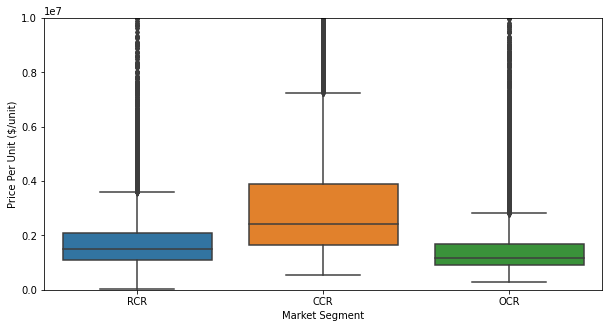

In [22]:
# Need to speicfy figure size before displaying boxplot below
plt.figure(figsize=[10,5])

sns.boxplot(x="Market Segment", y="Price Per Unit ($/unit)", data=privateDf)
# Max value is 10 million dollars
plt.ylim(0,10000000)

# From the boxplot below, we can tell that the CCR region median is higher than RCR and OCR.
# Also we do not intend to drop any outliers as they will increase varibility.
# There's actually more data points above 10 million but I've set the limit so that we can see the majority of the values below 10 million dollars.

<AxesSubplot:xlabel='Type', ylabel='Price Per Unit ($/unit)'>

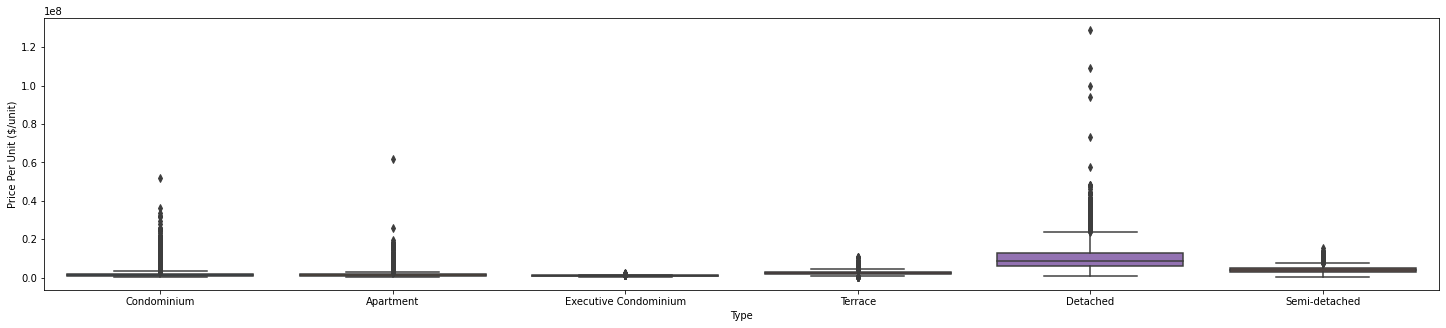

In [23]:
plt.figure(figsize=[25,5])

# So from here, we know there is something wrong with the type column.
# Regardless, one would expect that an actual landed properties will have outliers be have more resale values compared to condos and apartments though our boxplot says otherwise.
# Refer to another box plot below for values below 20 million.
sns.boxplot(x="Type", y="Price Per Unit ($/unit)", data=privateDf)

(0.0, 20000000.0)

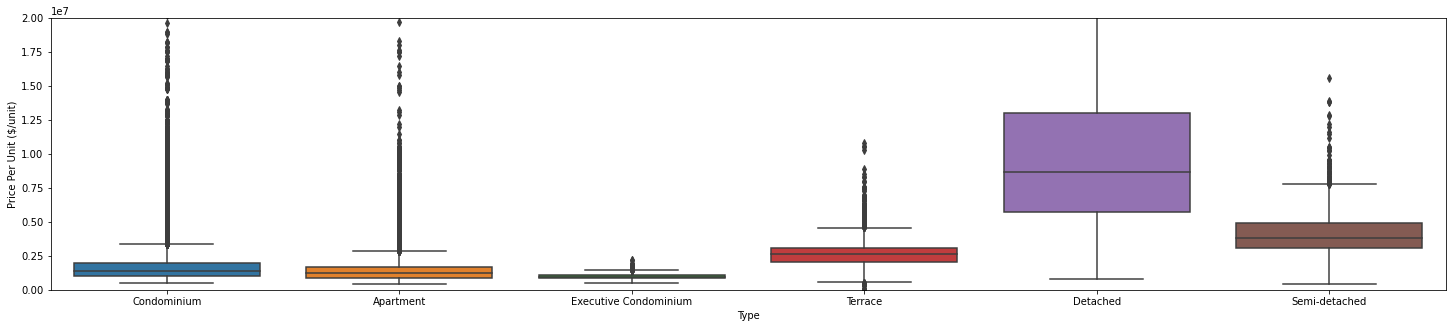

In [24]:
plt.figure(figsize=[25,5])

# Now over here, median resale value for detached houses are higher than other columns.
sns.boxplot(x="Type", y="Price Per Unit ($/unit)", data=privateDf)
plt.ylim(0,20000000)


(0.0, 20000000.0)

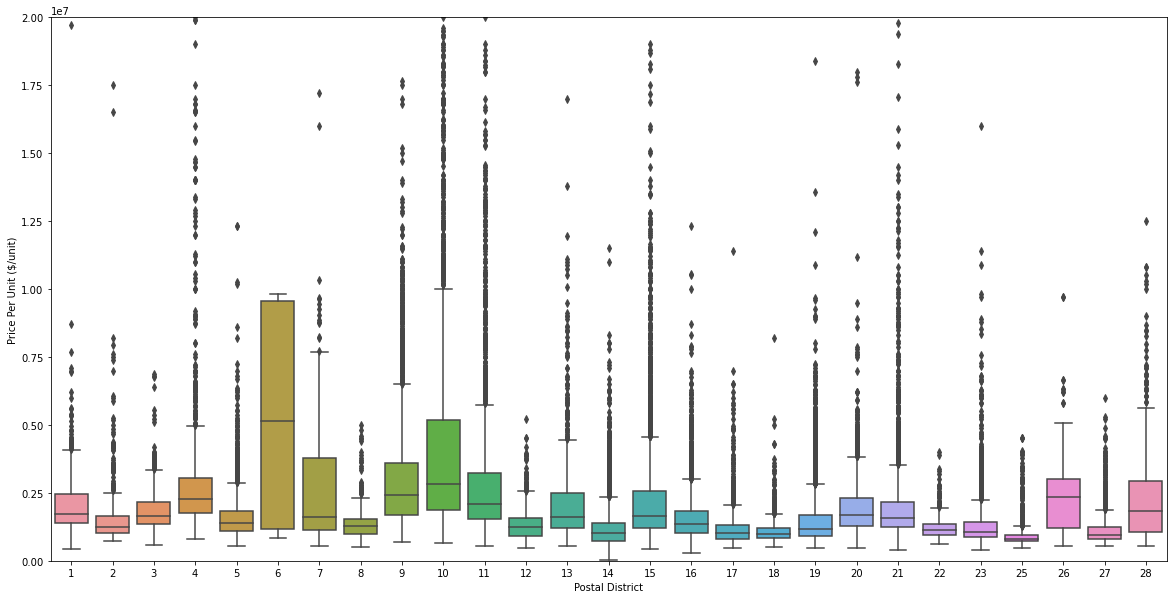

In [25]:
plt.figure(figsize=[20,10])

# Comparing median values, postal district 6 is the highest compared to the rest. Postal District 6 is located at high street and Beach Road which is near the CBD.
# It seems that our data has a lot of outliers since there is a variety of resale value of private houses compared to public housing.
sns.boxplot(x="Postal District", y="Price Per Unit ($/unit)", data=privateDf)
plt.ylim(0,20000000)


<AxesSubplot:>

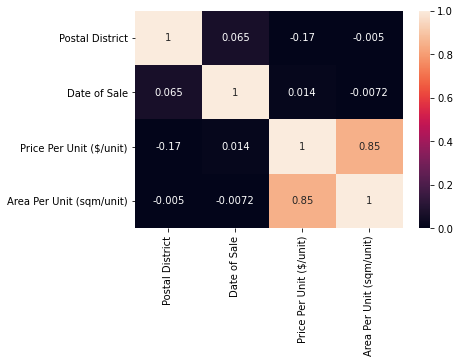

In [26]:
# There is high correlation between area and unit price of the house
sns.heatmap(privateDf.corr(), vmin=0, vmax=1, annot=True)

In [27]:
# Check the number of rows and columns
privateDf.shape

(63597, 9)

## Feature Engineering
- One hot encode categorical columns for flat_models, town, storey_range, flat_type.
- We also extract information from the tenure column.

In [28]:
# Extracting info from tenure
tenureEx = privateDf["Tenure"].str.split(" ", n = 5, expand = True)
tenureEx.head()

,0,1,2,3,4,5
0,99,yrs,lease,commencing,from,2012
1,99,yrs,lease,commencing,from,1999
2,99,yrs,lease,commencing,from,2006
3,99,yrs,lease,commencing,from,2008
4,956,yrs,lease,commencing,from,1928


In [29]:
# We retrieve rows freehold value
freeholdVal = tenureEx[tenureEx[0] == "Freehold"]
freeholdVal = freeholdVal.drop([1,2,3,4,5], axis=1)
freeholdVal.head()

,0
15,Freehold
16,Freehold
23,Freehold
33,Freehold
35,Freehold


In [30]:
# We retrieve rows without freehold value
tenureInfo = tenureEx[tenureEx[0] != "Freehold"]
tenureDuration = tenureInfo.drop([1,2,3,4,5], axis=1)
tenureStartYear = tenureInfo.drop([0,1,2,3,4], axis=1)
tenureDuration.head()

,0
0,99
1,99
2,99
3,99
4,956


In [31]:
# Concat extract values to privatedf

privateDf ['Freehold']= pd.concat([freeholdVal], axis=0)
privateDf['Tenure Duration (Years)'] = pd.concat([tenureDuration], axis=0)
privateDf['Start Lease Date'] = pd.concat([tenureStartYear], axis=0)

# Fill null values with 0 and replace 'Freehold' value with 1
privateDf['Freehold'] = privateDf['Freehold'].fillna(0)
privateDf['Freehold'] = privateDf['Freehold'].replace({"Freehold": 1})

#Convert start lease date to datetime format
privateDf['Start Lease Date'] = pd.to_datetime(privateDf['Start Lease Date'], errors='coerce')

# Convert start lease date to ordinal type
privateDf['Start Lease Date'] = privateDf['Start Lease Date'].map(dt.datetime.toordinal)


In [32]:
# Fill tenure duration with 0 since it is freehold
privateDf['Tenure Duration (Years)'] = privateDf['Tenure Duration (Years)'].fillna(0)

# Convert tenure duration to numeric type
privateDf['Tenure Duration (Years)'] = pd.to_numeric(privateDf['Tenure Duration (Years)'])

In [33]:
# Drop Tenure Column after extracting the information
privateDf = privateDf.drop(['Tenure'], axis=1)
privateDf.head()

,Type,Postal District,Market Segment,Type of Area,Floor Level,Date of Sale,Price Per Unit ($/unit),Area Per Unit (sqm/unit),Freehold,Tenure Duration (Years),Start Lease Date
0,Condominium,3,RCR,Strata,41 to 45,737911,2000000.0,93.0,0,99,734503
1,Condominium,4,RCR,Strata,01 to 05,737911,2300000.0,141.0,0,99,729755
2,Apartment,2,CCR,Strata,36 to 40,737911,1251300.0,60.0,0,99,732312
3,Condominium,3,RCR,Strata,16 to 20,737911,2530000.0,169.0,0,99,733042
4,Condominium,5,OCR,Strata,01 to 05,737911,1150000.0,73.0,0,956,703822


In [39]:
privateDf['Postal District'] = privateDf['Postal District'].astype('object')

In [40]:
categorical_feature_mask = privateDf.dtypes == object
categorical_cols = privateDf.columns[categorical_feature_mask].tolist()
categorical_cols

['Type', 'Postal District', 'Market Segment', 'Type of Area', 'Floor Level']

Categorical Columns = 'Type', 'Postal District', 'Market Segment', 'Type of Area', 'Floor Level'

In [41]:
privateDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63597 entries, 0 to 63880
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Type                      63597 non-null  object 
 1   Postal District           63597 non-null  object 
 2   Market Segment            63597 non-null  object 
 3   Type of Area              63597 non-null  object 
 4   Floor Level               63597 non-null  object 
 5   Date of Sale              63597 non-null  int64  
 6   Price Per Unit ($/unit)   63597 non-null  float64
 7   Area Per Unit (sqm/unit)  63597 non-null  float64
 8   Freehold                  63597 non-null  int64  
 9   Tenure Duration (Years)   63597 non-null  int64  
 10  Start Lease Date          63597 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 7.8+ MB


In [ ]:
# categorical_columns = ['Type', 'Postal District', 'Market Segment', 'Type of Area', 'Floor Level']

In [42]:
# Call one hot encoder and one hot encode categorical columns
ohe = OneHotEncoder(categories = "auto", handle_unknown='ignore', sparse=False)
ohe.fit(privateDf[categorical_cols])

with open('privateResaleEncoder.pickle', 'wb') as f:
    pickle.dump(ohe, f)

cat_ohe = ohe.transform(privateDf[categorical_cols]).astype('uint8')

# #Create a Pandas DataFrame of the hot encoded column
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_cols))

df_ohe = pd.concat([privateDf, ohe_df],join='inner', axis=1).drop(columns = categorical_cols, axis=1)

In [45]:
df_ohe.head()

,Date of Sale,Price Per Unit ($/unit),Area Per Unit (sqm/unit),Freehold,Tenure Duration (Years),Start Lease Date,Type_Apartment,Type_Condominium,Type_Detached,Type_Executive Condominium,...,Floor Level_31 to 35,Floor Level_36 to 40,Floor Level_41 to 45,Floor Level_46 to 50,Floor Level_51 to 55,Floor Level_56 to 60,Floor Level_61 to 65,Floor Level_66 to 70,Floor Level_71 to 75,Floor Level_B1 to B5
0,737911,2000000.0,93.0,0,99,734503,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,737911,2300000.0,141.0,0,99,729755,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,737911,1251300.0,60.0,0,99,732312,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,737911,2530000.0,169.0,0,99,733042,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,737911,1150000.0,73.0,0,956,703822,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63335 entries, 0 to 63590
Data columns (total 61 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date of Sale                63335 non-null  int64  
 1   Price Per Unit ($/unit)     63335 non-null  float64
 2   Area Per Unit (sqm/unit)    63335 non-null  float64
 3   Freehold                    63335 non-null  int64  
 4   Tenure Duration (Years)     63335 non-null  int64  
 5   Start Lease Date            63335 non-null  int64  
 6   Type_Apartment              63335 non-null  uint8  
 7   Type_Condominium            63335 non-null  uint8  
 8   Type_Detached               63335 non-null  uint8  
 9   Type_Executive Condominium  63335 non-null  uint8  
 10  Type_Semi-detached          63335 non-null  uint8  
 11  Type_Terrace                63335 non-null  uint8  
 12  Postal District_1           63335 non-null  uint8  
 13  Postal District_2           633

In [ ]:
# One hot encode these categorical columns
# privateDf = pd.get_dummies(privateDf, columns=['Type','Postal District', 'Market Segment','Type of Area','Floor Level'])
# privateDf.head()

In [ ]:
# privateDf.info()

## Training Model - Regression
- Prob will decide which algo will fit the best for this project.
- Needs to have validation dataset as well

In [ ]:
# X contains features
X = privateDf.drop(['Price Per Unit ($/unit)'], axis=1)

# y contains targets to be predicted
y = privateDf['Price Per Unit ($/unit)']

# Convert to numpy array since XGBoost doesn't like pandas
X = X.values
y = y.values

# 80% training data and 20% data for test data and validation data
X_train, X_testTotal, y_train, y_testTotal = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_validation, X_test, y_validation, y_test = train_test_split(X_testTotal, y_testTotal, test_size=0.5, random_state=42, shuffle=True)

#### Linear Regression
We will use a simple linear regression alogrithm for this section.

In [ ]:
reg = LinearRegression()
reg.fit(X_train,y_train)

In [ ]:
# Predict results
y_predTrain = reg.predict(X_train)
y_predTest = reg.predict(X_test)

# MAE Computation
mae = mean_absolute_error(y_train, y_predTrain)
print("Mean Absolute Error on training data: {:.4f}".format(mae))

mae = mean_absolute_error(y_test, y_predTest)
print("Mean Absolute Error on test data: {:.4f}\n".format(mae))

# MSE Computation
mse = mean_squared_error(y_train, y_predTrain)
print("Mean Squared Error on training data: {:.4f}".format(mse))

mse = mean_squared_error(y_test, y_predTest)
print("Mean Squared Error on test data: {:.4f}\n".format(mse))

# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_train, y_predTrain))
print("Root Mean Squared Error on training data: {:.4f}".format(rmse))

rmse = np.sqrt(mean_squared_error(y_test, y_predTest))
print("Root Mean Squared Error on test data: {:.4f}\n".format(rmse))

# R Square Computation
r2 = r2_score(y_train, y_predTrain)
print("R Square value on training data: {:.4f}".format(r2))

r2 = r2_score(y_test, y_predTest)
print("R Square value on test data: {:.4f}".format(r2))


#### Results
- Mean Absolute Error on training data: 497817.9243
- Mean Absolute Error on test data: 502799.9179

- Mean Squared Error on training data: 1184151336175.0964
- Mean Squared Error on test data: 847049652335.5657

- Root Mean Squared Error on training data: 1088187.1788
- Root Mean Squared Error on test data: 920353.0042

- R Square value on training data: 0.8038
- R Square value on test data: 0.8363

### XGBoost
- We will be using XGBoost for this section.
- XGBoost is widely used among Kaggle competitions and often used on large-scale problems.
- Since XGBoost gives great performance and accuracy on regression and classification problems.
- Though we only use it for regression problems here.

In [ ]:
xgb = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 100, max_depth=3, reg_alpha=4)

In [ ]:
# Hyperparameters used to tune our model
param_grid = {'min_child_weight':range(1,4),'reg_lambda':range(4,8,2)}
gridModel = GridSearchCV(estimator=xgb, param_grid=param_grid)

# Code below is used to cut down on memory needed to copy data
X_train = np.ascontiguousarray(X_train)
y_train = np.ascontiguousarray(y_train)

eval_metrics = ['rmse','mae','mape']
eval_sets = [(X_train, y_train), (X_validation, y_validation)]

# We fit the model here
gridModel.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_sets)

In [ ]:
# Here we see the best scores
best_score = gridModel.best_score_
print(best_score)

Best Score: 0.8595515574962318

In [ ]:
# And here we see the best hyperparameters
# I have tested using gamma parameter and its best at 0
best_params = gridModel.best_params_
print(best_params)

Best parameters: {'gamma': 0, 'max_depth': 3, 'min_child_weight': 2, 'reg_alpha': 4, 'reg_lambda': 4}

In [ ]:
# We save the model
best_model = gridModel.best_estimator_
print(best_model)

In [ ]:
# We save the model in pickel format
pickle.dump(best_model, open("xgb_private_resale.pickle", "wb"))

In [ ]:
gridModel = pickle.load(open('xgb_private_resale.pickle', 'rb'))

In [ ]:
results = gridModel.best_estimator_.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
plt.ylabel('Root Mean Square Error (RMSE)')
plt.title('XGBoost Regression RMSE')
plt.show()

In [ ]:
# Predict results
y_predTrain = gridModel.predict(X_train)
y_predTest = gridModel.predict(X_test)

# MAE Computation
mae = mean_absolute_error(y_train, y_predTrain)
print("Mean Absolute Error on training data: {:.4f}".format(mae))

mae = mean_absolute_error(y_test, y_predTest)
print("Mean Absolute Error on test data: {:.4f}\n".format(mae))

# MSE Computation
mse = mean_squared_error(y_train, y_predTrain)
print("Mean Squared Error on training data: {:.4f}".format(mse))

mse = mean_squared_error(y_test, y_predTest)
print("Mean Squared Error on test data: {:.4f}\n".format(mse))

# RMSE Computation
mse = np.sqrt(mean_squared_error(y_train, y_predTrain))
print("Root Mean Squared Error on training data: {:.4f}".format(mse))

mse = np.sqrt(mean_squared_error(y_test, y_predTest))
print("Root Mean Squared Error on test data: {:.4f}\n".format(mse))

# R Square Computation
r2 = r2_score(y_train, y_predTrain)
print("R Square value on training data: {:.4f}".format(r2))

r2 = r2_score(y_test, y_predTest)
print("R Square value on test data: {:.4f}".format(r2))


#### Results
- Mean Absolute Error on training data: 319989.2777
- Mean Absolute Error on test data: 335313.0674

- Mean Squared Error on training data: 486963872926.5487
- Mean Squared Error on test data: 548929200538.7715

- Root Mean Squared Error on training data: 697827.9680
- Root Mean Squared Error on test data: 740897.5641

- R Square value on training data: 0.9193
- R Square value on test data: 0.8939

### Chosen ML Model
- XGBoost will be chosen for predicting housing resale prices as it performs better than the simple linear regression.
- Reasons
    - Mean Absolute Error is lower by half using XGBoost
    - Root Mean Squared Error is lower by half using XGBoost
    - R Square value is higher using XGBoost